<a href="https://colab.research.google.com/github/therishabhmittal-05/NLP/blob/main/LanguagePrediction_basic_rnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Given the word, predict which language it belongs to.**

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import string
import unicodedata
from torch.utils.data import Dataset, random_split
import glob
import os
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
allowed_chars = string.ascii_letters + " .,;'"+ "_"
n_letters = len(allowed_chars)

def unicode_ascii(s):
  return "".join(
      c for c in unicodedata.normalize("NFD", s)
      if unicodedata.category(c) != 'Mn'
      and c in allowed_chars
  )

In [4]:
print(unicode_ascii('Ślusàrski'))

Slusarski


In [5]:
# Letter to index
def letter_index(letter):
  if letter not in allowed_chars:
    return allowed_chars.find('_')
  else:
     return allowed_chars.find(letter)

# Sentence to tensor
def sent_tensor(sent):
  tensor = torch.zeros(len(sent), 1, n_letters)
  for li, letter in enumerate(sent):
    tensor[li][0][letter_index(letter)] = 1
  return tensor

In [6]:
sent_tensor('Rishabh Mittal')
sent_tensor('$')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 1.]]])

In [7]:
class LangDs(Dataset):

  def __init__(self, data_dir):
    self.data_dir = data_dir
    labels_set = set()

    self.data = []
    self.data_tensors = []
    self.labels = []
    self.label_tensors=[]

    text_files = glob.glob(os.path.join(data_dir, '*txt'))
    for filename in text_files:
      label = os.path.splitext(os.path.basename(filename))[0]
      labels_set.add(label)
      lines = open(filename, encoding='utf-8').read().strip().split('\n')
      for name in lines:
        self.data.append(name)
        self.data_tensors.append(sent_tensor(name))
        self.labels.append(label)

      self.labels_uniq = list(labels_set)
      for idx in range(len(self.labels)):
        temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
        self.label_tensors.append(temp_tensor)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data_item = self.data[idx]
    data_label = self.labels[idx]
    data_tensor = self.data_tensors[idx]
    label_tensor = self.label_tensors[idx]

    return data_item, data_label, data_tensor, label_tensor

In [8]:
alldata = LangDs('/content/drive/MyDrive/Colab Notebooks/data/data/names')

In [9]:
train_set, val_set = random_split(alldata,
 [(int)(len(alldata)*0.85), len(alldata) - (int)(len(alldata)*0.85)],
                                  generator=torch.Generator().manual_seed(42))

In [10]:
print(len(train_set))

17062


In [26]:
val = set()
for i in range(len(val_set)):
  val.add(val_set[i][1])

print(val)

{'German', 'Scottish', 'Vietnamese', 'Czech', 'Italian', 'Russian', 'Portuguese', 'Greek', 'Irish', 'Polish', 'Korean', 'English', 'Spanish', 'French', 'Arabic', 'Dutch', 'Japanese', 'Chinese'}


In [12]:
indices = list(range(len(train_set)))
print(len(indices))
random.shuffle(indices)
batches = np.array_split(indices, len(indices) // 64)
print(len(batches[37]))

17062
65


In [13]:
class LangModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LangModel, self).__init__()

    self.lstm = nn.LSTM(input_size, hidden_size)
    self.fc = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, senttensor):
    lstm_out, (hn, cn) = self.lstm(senttensor)
    ahat = self.fc(hn[-1])
    yhat = self.softmax(ahat)
    return yhat

In [14]:
n_hidden = 128
model = LangModel(n_letters, n_hidden, len(alldata.labels_uniq)).to(device)
print("Device: cuda" if next(model.parameters()).is_cuda else "Device: cpu")
print(model)

Device: cuda
LangModel(
  (lstm): LSTM(58, 128)
  (fc): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [15]:
input = sent_tensor('Alexandra').to(device)
output = model(input)
def get_label_from_output(output, output_labels):
  _, top_i = output.topk(1)
  label_i = top_i[0].item()
  return output_labels[label_i], label_i
print(get_label_from_output(output, alldata.labels_uniq))

('Portuguese', 6)


In [17]:
def train(model, train_data, n_epochs=10, batch_size=64, report=50, lr = 0.2, criterion = nn.NLLLoss()):
  losses=[] # to store loss after each epoch for plotting
  accuracies=[]
  model.train() # train mode
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  data_test = set()
  print(f"length of train data: {len(train_data)}")
  for iter in range(1, n_epochs+1):
    running_loss = 0.0 # One epoch loss

    # One epoch accuracy
    correct = 0.0
    total = 0.0

    # create some minibatches
    # we cannot use dataloaders because each of our names is a different length
    indices = list(range(len(train_data)))
    random.shuffle(indices)
    batches = np.array_split(indices, max(1, len(indices) // batch_size))

    for idx, batch in enumerate(batches):
      batch_loss = 0.0 # per batch loss, added to running loss after each batch run
      optimizer.zero_grad()

      # For each sample in the batch
      for i in batch:
        (data_item, data_label, data_tensor, label_tensor) = train_data[i]
        data_test.add(data_label)
        data_tensor = data_tensor.to(device)
        label_tensor = label_tensor.to(device)
        output = model(data_tensor)
        loss = criterion(output, label_tensor)
        batch_loss += loss
        predicted_label = torch.argmax(output, dim=1)
        correct += (predicted_label == label_tensor).sum().item()
        total += label_tensor.size(0)

      batch_loss /= len(batch)
      batch_loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=3)
      optimizer.step()
      running_loss += batch_loss.item()

    epoch_loss = running_loss/len(batches)
    losses.append(epoch_loss)

    epoch_acc = correct/total
    accuracies.append(epoch_acc)

    if(iter%report==0):
      print(f"Epoch: {iter} | Epoch Loss: {epoch_loss} | Accuracy: {epoch_acc} ")

  return losses, accuracies, data_test # list of losses at each epoch

In [19]:
start = time.time()
losses, accuracies, data_test = train(model, train_set, n_epochs=2, report=5)
end = time.time()

print(f"training took {end-start}s")

length of train data: 17062
training took 45.539283752441406s


In [20]:
print(data_test)

{'German', 'Scottish', 'Vietnamese', 'Czech', 'Italian', 'Russian', 'Dutch', 'Portuguese', 'Greek', 'Irish', 'Polish', 'Korean', 'Spanish', 'French', 'Arabic', 'English', 'Japanese', 'Chinese'}


In [18]:
input = sent_tensor('Jing').to(device)
output = model(input)
def get_label_from_output(output, output_labels):
  _, top_i = output.topk(1)
  label_i = top_i[0].item()
  return output_labels[label_i], label_i
print(get_label_from_output(output, alldata.labels_uniq))

('Portuguese', 2)


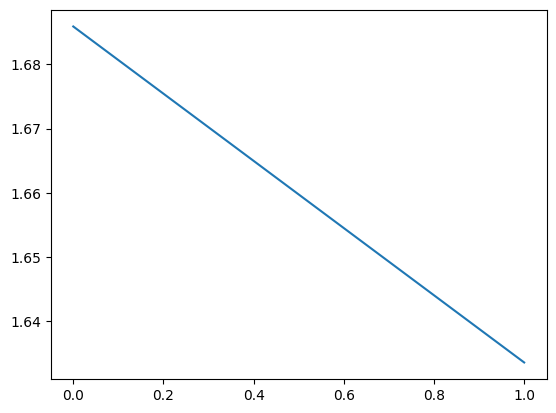

In [21]:
plt.plot(losses)
plt.show()

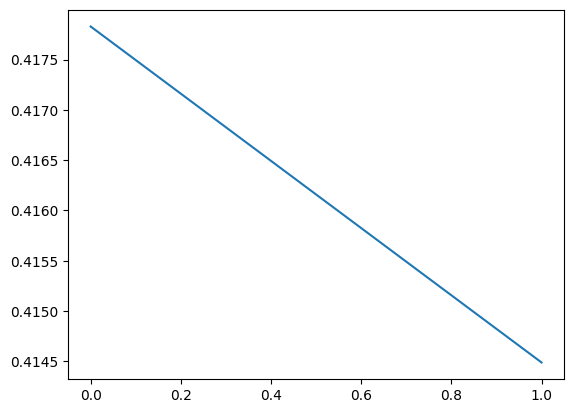

In [22]:
plt.plot(accuracies)
plt.show()

In [34]:
def evaluate(model, val_data, inv_label_map, classes, ):
  model.eval()
  correct = 0
  total = 0
  confusion = torch.zeros(len(classes), len(classes))
  confusion = confusion.to(device)
  print(f"length of val data: {len(val_data)}")
  predicted_labels_set = set()
  with torch.no_grad():
    for i in range(len(val_data)):

      (data_item, data_label, data_tensor, label_tensor) = val_data[i]
      data_tensor = data_tensor.to(device)
      label_tensor = label_tensor.to(device)
      output = model(data_tensor)

      predicted = torch.argmax(output, dim=1).item()
      predicted_label_ = inv_label_map[predicted]  # map back to label string
      predicted_labels_set.add(predicted_label_)
      # accuracy
      predicted_label = torch.argmax(output, dim=1)
      correct += (predicted_label == label_tensor).sum().item()
      total += label_tensor.size(0)

      # Confusion matrix
      for true, pred in zip(label_tensor.view(-1), predicted_label.view(-1)):
        confusion[true.long(), pred.long()] += 1

  for i in range(len(classes)):
    denom = confusion[i].sum()
    if denom > 0:
      confusion[i] /= denom

  accuracy = correct/total
  print(f"Evaluation Accuracy: {accuracy}")

  # Set up plot
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
  fig.colorbar(cax)

  # Set up axes
  ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
  ax.set_yticks(np.arange(len(classes)), labels=classes)

  # Force label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  # sphinx_gallery_thumbnail_number = 2
  plt.show()
  return accuracy, predicted_labels_set

In [35]:
label_map = {
    'Greek': 0,
    'Arabic': 1,
    'Portuguese': 2,
    'Russian': 3,
    'Scottish': 4,
    'Irish': 5,
    'Italian': 6,
    'Japanese': 7,
    'Dutch': 8,
    'French': 9,
    'Polish': 10,
    'Korean': 11,
    'Spanish': 12,
    'Chinese': 13,
    'German': 14,
    'Vietnamese': 15,
    'English': 16,
    'Czech': 17
}
inv_label_map = {v: k for k, v in label_map.items()}


length of val data: 3012
Evaluation Accuracy: 0.4123505976095618


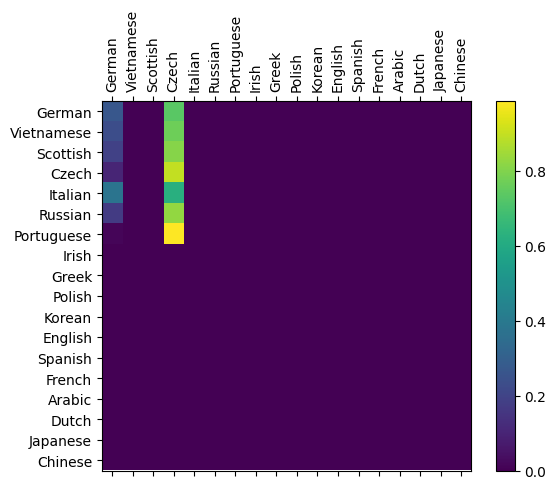

In [36]:
evaluation_accuracy, predicted_labels_set = evaluate(model, val_set, inv_label_map, classes = alldata.labels_uniq)

In [37]:
print(predicted_labels_set)

{'Greek', 'Russian'}


In [25]:
print(alldata.labels_uniq)

['Greek', 'Arabic', 'Portuguese', 'Russian', 'Scottish', 'Irish', 'Italian', 'Japanese', 'Dutch', 'French', 'Polish', 'Korean', 'Spanish', 'Chinese', 'German', 'Vietnamese', 'English', 'Czech']


In [38]:
from collections import Counter
print(Counter([label for (_, label, _, _) in train_set]))

Counter({'Russian': 8038, 'English': 3107, 'Arabic': 1690, 'Japanese': 831, 'Italian': 611, 'German': 607, 'Czech': 452, 'Dutch': 255, 'Spanish': 245, 'French': 232, 'Chinese': 224, 'Irish': 196, 'Greek': 175, 'Polish': 121, 'Korean': 83, 'Scottish': 76, 'Vietnamese': 61, 'Portuguese': 58})
